In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import sklearn
import os
import subprocess
import json
import sys
import csv
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.pyplot import subplots
import csv
import re

In [2]:
with open('barcode.bed','r') as f:
    barcode = []
    for line in f:
        data_line = line.rstrip().split('\t')
        data_line = [i for i in data_line]
        barcode.append(data_line)

df_bar = pd.DataFrame(barcode)
df_bar.drop([0,5,6,7], axis=1, inplace=True)

for i, x in enumerate(df_bar[3]):
    x = x.split('.')
    # if re.match(x[0], '^lineage*'):
    if re.search("lineage[1-9]", x[0]):
        df_bar[3][i]=re.search('[1-9]',x[0]).group()
    elif re.search("lineage[1-9]", x[0])==None:
        df_bar[3][i]='other'

df_bar = df_bar[df_bar[3]!='other']
df_bar_array = np.array(df_bar)

In [3]:
with open('fst_results_clean_fst_1_for_paper.csv','r') as f:
    barcode = []
    for line in f:
        data_line = line.rstrip().split(',')
        data_line = [i for i in data_line]
        barcode.append(data_line)

df_bar = pd.DataFrame(barcode)
df_bar = df_bar.iloc[1:, :8]
df_bar.drop([0,3,4,5,6], axis=1, inplace=True)

df_bar['lin_'] = 'other'
for i, x in enumerate(df_bar[1]):
    if re.search("^[1-9]", x):
        df_bar['lin_'][i]=re.search('^[1-9]',x).group()
    # else re.search("^[1-9]", x)==None:

    else:
        df_bar['lin_'][i]='other'

df_bar = df_bar[df_bar['lin_']!='other']
df_bar_array = np.array(df_bar)

In [4]:
df_bar['lin_'].unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [176]:
VCF_FILE_NAME = 'ERR6634978-ERR6635032-3070.vcf.gz' #this needs to be changed as well 
VCF_PATH='/mnt/storage7/lwang/trial_tb_philippines/data/processed/seqtk/freebayesVCF'
NAME_FILE='/mnt/storage7/lwang/trial_tb_philippines/data/seqtk/sample_name.txt'

VCF_FILE_PATH = os.path.join(VCF_PATH, VCF_FILE_NAME)


with open('ROAO_DP_ALT.csv', 'w') as f:
    subprocess.run("bcftools view -c 1 -m2 -M2 -T ^new_exclusion.bed %s | bcftools query -f '[%%POS,%%REF,%%ALT,%%GT,%%AD,%%DP\\n]'" % VCF_FILE_PATH, shell=True, stdout=f, text=True)
        # subprocess.run("bcftools view -c 1 -m2 -M2 -T ^new_exclusion.bed %s | bcftools query -f '%%POS\\t%%REF\\t%%ALT[\\t%%GT\\t%%AD\\n]'" % vcf_file, shell=True, stdout=f, text=True)

#[%POS,%RO,%AO,%DP,%ALT\n]

In [177]:
with open('ROAO_DP_ALT.csv', 'r') as f:

    data = []
    num_col=0
    for line in f:
        data_line = line.rstrip().split('\n')
        data_line = data_line[0].split(',')
        data_line = [i for i in data_line]
        if len(data_line) > num_col:
            num_col = len(data_line)
        data.append(data_line)

    #print(num_col) #outputing the length of column in the dataframe
    num_RO = num_col - 1
    #print(num_RO)


In [178]:
#removing all the files with more than 1 AO count

data1 = []

for i in data:
    if len(i) == 7:
        data1.append(i)
data1_array = np.array(data1)

In [179]:
data1_array=np.delete(data1_array, 3, 1)

In [180]:
data1_array

array([['1302', 'C', 'A', '180', '19', '199'],
       ['1977', 'A', 'G', '0', '188', '188'],
       ['2532', 'T', 'C', '168', '19', '187'],
       ...,
       ['4408156', 'A', 'C', '18', '156', '174'],
       ['4410386', 'G', 'T', '200', '38', '238'],
       ['4411016', 'G', 'A', '157', '17', '175']], dtype='<U64')

In [181]:
# #run this only once, otherwise it will take too long
anchored = []
for x in data1_array:
    for y in df_bar_array:
        if int(x[0]) >= int(y[1]) and int(x[0]) < int(y[1])+2 and x[2] == y[2]:
            insert = np.append(x, y[3])
            anchored.append(insert)
            pass


In [182]:
anchored_array = np.array(anchored)
for i in range(1,10):
    if len(anchored_array[anchored_array[:, 6]==str(i)]) == 0:
        pass
    else:
        print(f'lineage{i}', len(anchored_array[anchored_array[:, 6]==str(i)]), 'Percentage:',len(anchored_array[anchored_array[:, 6]==str(i)])/len(anchored))

print(len(anchored))


lineage1 549 Percentage: 0.7449118046132972
lineage4 187 Percentage: 0.2537313432835821
lineage5 1 Percentage: 0.0013568521031207597
737


1286

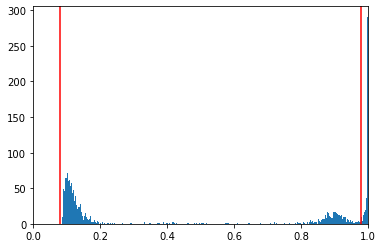

In [186]:

data1_cutoff = []

def cut_off (downcut, upcut):
    graph =[]
    for i in data1_array:
        graph.append(int(i[4])/int(i[5]))
        if int(i[4])/int(i[5]) > downcut and int(i[4])/int(i[5]) < upcut:
            data1_cutoff.append(i)
        
    fig, ax = plt.subplots()
    ax.hist(graph, bins=300)
    ax.axvline(upcut, color='red')
    ax.axvline(downcut, color='red')
    ax.set_xlim((0,1))

cut_off(0.08, 0.98)
len(data1_cutoff)


In [187]:
#freq

X = anchored_array[:,4:6].astype(float)
y = anchored_array[:,6].reshape(-1, 1).astype(float)

X = X[:,0]/X[:,1]#freq
# X[:,0] = (X[:,0] - np.mean(X[:,0])) / np.std(X[:,0])
# X[:,1] = (X[:,1] - np.mean(X[:,1])) / np.std(X[:,1])
data1_array_test = np.array(data1_cutoff)[:,4:6].astype(float)

data1_array_test = data1_array_test[:,0]/data1_array_test[:,1] #freq
# data1_array_test[:,1] = (data1_array_test[:,1] - np.mean(data1_array_test[:,1])) / np.std(data1_array_test[:,1])
# data1_array_test[:,2] = (data1_array_test[:,1] - np.mean(data1_array_test[:,2])) / np.std(data1_array_test[:,2])

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X.reshape(-1, 1), y)
predictions = []
for i in data1_array_test:
    pred = neigh.predict(i.reshape(-1, 1))
    predictions.append(pred)
    # X = np.append(X, i[1:3]).reshape(-1,2) #fiting predicted points back into model, doesn't really make a difference
    # y = np.append(y, pred).reshape(-1,1)
    # neigh.fit(X, y)



/mnt/storage7/lwang/miniconda3/envs/ml-s7/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [188]:
prediction_list = []
for i in predictions:
    prediction_list.append(int(i))

for i in range(1,10):
    print(f'lineage{i}:', prediction_list.count(i))

print(prediction_list.count(1)/len(prediction_list), prediction_list.count(4)/len(prediction_list))


lineage1: 909
lineage2: 0
lineage3: 0
lineage4: 377
lineage5: 0
lineage6: 0
lineage7: 0
lineage8: 0
lineage9: 0
0.7068429237947123 0.2931570762052877


In [174]:
#non freq
X = anchored_array[:,4:6].astype(float)
y = anchored_array[:,6].reshape(-1, 1).astype(float)

# X[:,0] = (X[:,0] - np.mean(X[:,0])) / np.std(X[:,0])
# X[:,1] = (X[:,1] - np.mean(X[:,1])) / np.std(X[:,1])
data1_array_test = np.array(data1_cutoff)[:,4:6].astype(float)

# data1_array_test[:,1] = (data1_array_test[:,1] - np.mean(data1_array_test[:,1])) / np.std(data1_array_test[:,1])
# data1_array_test[:,2] = (data1_array_test[:,1] - np.mean(data1_array_test[:,2])) / np.std(data1_array_test[:,2])

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X, y)
predictions = []
for i in data1_array_test:
    pred = neigh.predict([i])
    predictions.append(pred)
    # X = np.append(X, i[1:3]).reshape(-1,2) #fiting predicted points back into model, doesn't really make a difference
    # y = np.append(y, pred).reshape(-1,1)
    # neigh.fit(X, y)

/mnt/storage7/lwang/miniconda3/envs/ml-s7/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [175]:
prediction_list = []
for i in predictions:
    prediction_list.append(int(i))

for i in range(1,10):
    print(f'lineage{i}:', prediction_list.count(i))

print(prediction_list.count(1)/len(prediction_list), prediction_list.count(4)/len(prediction_list))


lineage1: 1454
lineage2: 0
lineage3: 0
lineage4: 355
lineage5: 0
lineage6: 0
lineage7: 0
lineage8: 0
lineage9: 0
0.8037589828634605 0.19624101713653952
